In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib.image as mpimg
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up Kaggle API
api = KaggleApi()
api.authenticate()

# Dataset details (from the Kaggle URL)
dataset_name = 'masoudnickparvar/brain-tumor-mri-dataset'

# Specify the folder where the dataset will be downloaded
download_path = 'brain_tumor_mri_dataset'

# Download the dataset
api.dataset_download_files(dataset_name, path=download_path, unzip=True)
print(f"Dataset downloaded and extracted to {download_path}")


OSError: Could not find kaggle.json. Make sure it's located in C:\Users\Vinisky\.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/

In [7]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder  # Make sure this is imported

# Image size to resize all images
image_size = 64  # You can change this as needed
data_dir = 'brain_tumor_mri_scans'  # Replace with the path to your dataset

# Function to load and preprocess images
def load_images(data_dir, image_size):
    images = []
    labels = []
    
    categories = os.listdir(data_dir)  # List all categories (folders) in the dataset
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for img_file in os.listdir(category_path):  # Iterate over image files in the category folder
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (image_size, image_size))  # Resize image to 64x64
            images.append(img)
            labels.append(category)
    
    images = np.array(images)
    labels = np.array(labels)
    
    # Normalize images
    images = images.astype('float32') / 255.0
    
    # Encode labels
    label_encoder = LabelEncoder()  # Ensure LabelEncoder is imported
    labels = label_encoder.fit_transform(labels)
    
    return images, labels, label_encoder

# Load and preprocess data
images, labels, label_encoder = load_images(data_dir, image_size)


In [8]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Define the path to the main dataset folder
dataset_path = 'brain_tumor_mri_scans/'

# Initialize variables to hold images and labels
images = []
labels = []

# Map class labels to integers
class_labels = {'healthy': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

# Read images and labels from the dataset
for class_name, label in class_labels.items():
    class_folder = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))  # Resize images to 224x224
        images.append(img)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images / 255.0  # Normalize to [0, 1]

# Expand dimensions for CNN input
images = np.expand_dims(images, axis=-1)

# One-hot encode the labels
labels = to_categorical(labels, num_classes=4)

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Define the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Output layer for 4 classes

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


C:\Users\Vinisky\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,168,900 (42.61 MB)

 Trainable params: 11,168,900 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Save the trained model
model.save('brain_tumor_segmentation_model.h5')


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.6076 - loss: 0.9566 - val_accuracy: 0.8376 - val_loss: 0.4569
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.8389 - loss: 0.4104 - val_accuracy: 0.8832 - val_loss: 0.3434
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8894 - loss: 0.2953 - val_accuracy: 0.9288 - val_loss: 0.2095
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.9225 - loss: 0.2003 - val_accuracy: 0.9387 - val_loss: 0.1853
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.9418 - loss: 0.1580 - val_accuracy: 0.9402 - val_loss: 0.1586
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9540 - loss: 0.1234 - val_accuracy: 0.9516 - val_loss: 0.1442
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.9610 - loss: 0.1093 - val_accuracy: 0.9373 - val_loss: 0.2075
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.9729 - loss: 0.0744 - val_accu

In [11]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.9725 - loss: 0.0878
Test accuracy: 0.9644


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


TypeError: Invalid shape () for image data

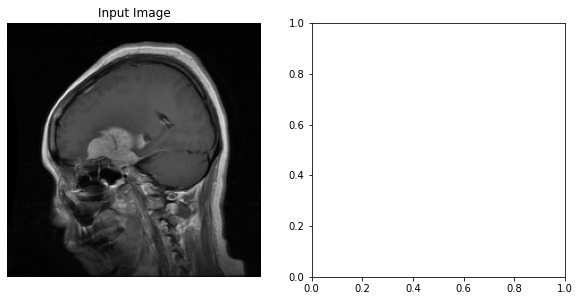

In [8]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

# Load the trained model
model = tf.keras.models.load_model('brain_tumor_segmentation_model.h5')

# Preprocess the input image
image_path = 'img.jpg'  # Change this to your input image file path
image = Image.open(image_path).convert('L')  # Convert to grayscale ('L' mode)
image = image.resize((224, 224))  # Resize to match model input size (224x224)
image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

# Expand dimensions for batch and add the channel dimension
input_data = np.expand_dims(image, axis=-1)  # Shape: (224, 224, 1)
input_data = np.expand_dims(input_data, axis=0)  # Shape: (1, 224, 224, 1)

# Perform the prediction (segmentation or classification)
predictions = model.predict(input_data)

# If it's a classification task (softmax output), extract the predicted class
predicted_class = np.argmax(predictions[0], axis=-1)  # For classification (multi-class)

# If it's a segmentation task, predictions will be a mask
# Extract the predicted mask for segmentation task
predicted_mask = np.argmax(predictions[0], axis=-1)  # For multi-class segmentation

# Visualize the results
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# Display segmentation mask (or predicted class for classification)
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='jet')  # Use 'jet' colormap for segmentation visualization
plt.title('Predicted Segmentation Mask')
plt.axis('off')

plt.show()

# Optional: Save the mask as an image file
plt.imsave('predicted_mask.png', predicted_mask, cmap='jet')
